# Network Wrapping

This notebook is heavily based on [this](https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439) wonderful, detailed tutorial of Faster-RCNN implementation.

### Contents:
- ??

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict
import cv2
from PIL import Image

In [3]:
import torch as t
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision as tv

In [4]:
mpl.rcParams.update({'font.size': 14})
CMAP = plt.get_cmap('rainbow')

In [5]:
IMAGES_PATH = Path(r'../annotator/sampled_frames')
LABELS = 'anchor_labels.pkl'
N_RESNET_LAYER_GROUPS = 6

### Initialization

Get training labels:

In [6]:
labels_data = pkl.load(open(LABELS, 'rb'))
labels, locations, anchors = \
    labels_data['anchor_labels'], labels_data['anchor_target_locations'], labels_data['anchor_boxes_locations']

print(labels.shape, locations.shape, anchors.shape)

(291600, 10) (291600, 4, 10) (291600, 4)


Get training image:

In [7]:
files = [f for f in os.listdir(IMAGES_PATH) if f.endswith('.png')]
image = Image.open(IMAGES_PATH/files[0])

W,H = image.size
print(W,H)

1920 1080


Transform image into pytorch format and prepare feature-map using Resnet base:

In [8]:
def normalize_images(images, imagenet_mean=(0.485,0.456,0.406), imagenet_std=(0.229,0.224,0.225), inline=False, verbose=False):
    X = images if inline else t.empty_like(images)
    if verbose:
        print('Pre shape,mean,std', X.shape, X.mean(), X.std())
    for i in range(X.shape[0]):
        for j in range(3):
            X[i,j,:,:] = ( X[i,j,:,:] - X[i,j,:,:].mean() ) / X[i,j,:,:].std() * imagenet_std[j] + imagenet_mean[j]
    if verbose:
        print('Post shape,mean,std', X.shape, X.mean(), X.std())
    return X

In [9]:
base_model = tv.models.resnet34(pretrained=True)

conv = nn.Sequential(*list(base_model.children())[:N_RESNET_LAYER_GROUPS])

for param in base_model.parameters():
    param.requires_grad = False

X = Variable(t.Tensor(t.tensor(np.array(image)).unsqueeze(0).permute(0,3,1,2).type('torch.FloatTensor')))
X = normalize_images(X, inline=True, verbose=True)
features = conv(X)

map_h,map_w = features.shape[-2:]
print('Feature-map shape:',features.shape)

feature_size = image.size[0] // features.shape[-1]
print('Feature size:',feature_size)

Pre shape,mean,std torch.Size([1, 3, 1080, 1920]) tensor(133.2651) tensor(51.7660)
Post shape,mean,std torch.Size([1, 3, 1080, 1920]) tensor(0.4490) tensor(0.2284)
Feature-map shape: torch.Size([1, 128, 135, 240])
Feature size: 8


Define RPN layers:

In [10]:
in_channels = features.shape[1] # 128
mid_channels = 2 * features.shape[1] # 256
n_anchor = 9 # Number of anchors at each location

conv_layer = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
reg_layer = nn.Conv2d(mid_channels, 4*n_anchor,   1, 1, 0)
cls_layer = nn.Conv2d(mid_channels, 1*n_anchor,   1, 1, 0)

In [11]:
# Initialize layers weights (according to paper's suggestion)

conv_layer.weight.data.normal_(0, 0.01)
conv_layer.bias.data.zero_()

reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_();

In [13]:
mid = conv_layer(features)
rel_loc_preds0 = reg_layer(mid)
scores_preds0 = cls_layer(mid)

print('For a single image - shapes of features, mid-layer, locations and scores:',
      features.shape, mid.shape, rel_loc_preds0.shape, scores_preds0.shape, sep='\n')

For a single image - shapes of features, mid-layer, locations and scores:
torch.Size([1, 128, 135, 240])
torch.Size([1, 256, 135, 240])
torch.Size([1, 36, 135, 240])
torch.Size([1, 9, 135, 240])


_______________

## RPN Wrapper

Wrap-up the Region-Proposal-Network to transform its outputs into actual proposals of objects detections and locations.

In [14]:
# TODO understand
rel_loc_preds = rel_loc_preds0.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
scores_preds = scores_preds0.permute(0, 2, 3, 1).contiguous()
objectness_score = scores_preds.view(1, map_h, map_w, 9, 1)[:, :, :, :, 0].contiguous().view(1, -1)
scores_preds = scores_preds.view(1, -1, 1)

print(rel_loc_preds.shape)
print(scores_preds.shape)
print(objectness_score.shape)

rel_loc_preds_np = rel_loc_preds[0].data.numpy()
objectness_score_np = objectness_score[0].data.numpy()

print(rel_loc_preds_np.shape)
print(objectness_score_np.shape)

torch.Size([1, 291600, 4])
torch.Size([1, 291600, 1])
torch.Size([1, 291600])
(291600, 4)
(291600,)


In [15]:
map_h*map_w*9

291600

In [16]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 6
max_size = 180

In [17]:
base_h = anchors[:, 2] - anchors[:, 0]
base_w = anchors[:, 3] - anchors[:, 1]
base_y0 = anchors[:, 0] + 0.5 * base_h
base_x0 = anchors[:, 1] + 0.5 * base_w
# force positive size
eps = np.finfo(base_h.dtype).eps
base_h = np.maximum(base_h, eps)
base_w = np.maximum(base_w, eps)

def locations_rel2abs(locs, H=H, W=W):
    n_anchors = locs.shape[0]
    n_images = locs.shape[1]
    # rel -> abs
    obj_y0 = base_y0 + base_h * locs[:,0]
    obj_x0 = base_x0 + base_w * locs[:,1]
    obj_h = base_h * np.exp(locs[:,2])
    obj_w = base_w * np.exp(locs[:,3])
    # y,x,h,w -> y1,x1,y2,x2
    y1 = obj_y0 - 0.5 * obj_h
    x1 = obj_x0 - 0.5 * obj_w
    y2 = obj_y0 + 0.5 * obj_h
    x2 = obj_x0 + 0.5 * obj_w
    # clip to image size
    y1 = np.clip(y1, 0, H)
    x1 = np.clip(x1, 0, W)
    y2 = np.clip(y2, 0, H)
    x2 = np.clip(x2, 0, W)
    # stack coordinates together
    return np.vstack((y1, x1, y2, x2)).transpose()

def locations_rel2abs_multi(locs, H=H, W=W):
    n_anchors = locs.shape[0]
    n_images = locs.shape[1]
    # rel -> abs
    obj_y0 = base_y0[:,np.newaxis] + base_h[:,np.newaxis] * locs[:,0,:]
    obj_x0 = base_x0[:,np.newaxis] + base_w[:,np.newaxis] * locs[:,1,:]
    obj_h = base_h[:,np.newaxis] * np.exp(locs[:,2,:])
    obj_w = base_w[:,np.newaxis] * np.exp(locs[:,3,:])
    # y,x,h,w -> y1,x1,y2,x2
    y1 = obj_y0 - 0.5 * obj_h
    x1 = obj_x0 - 0.5 * obj_w
    y2 = obj_y0 + 0.5 * obj_h
    x2 = obj_x0 + 0.5 * obj_w
    # clip to image size
    y1 = np.clip(y1, 0, H)
    x1 = np.clip(x1, 0, W)
    y2 = np.clip(y2, 0, H)
    x2 = np.clip(x2, 0, W)
    # stack coordinates together
    return np.hstack((y1[:,np.newaxis,:], x1[:,np.newaxis,:], y2[:,np.newaxis,:], x2[:,np.newaxis,:]))

print('Single image:',rel_loc_preds_np.shape, locations_rel2abs(rel_loc_preds_np).shape)
print('Multiple images:',locations.shape, locations_rel2abs_multi(locations).shape)

Single image: (291600, 4) (291600, 4)
Multiple images: (291600, 4, 10) (291600, 4, 10)


In [18]:
# --------------------------------------------------------
# Note: minor modifications were applied for this project
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License
# Written by Ross Girshick
# --------------------------------------------------------

import numpy as np

def nms(dets, scores, thresh=nms_thresh, n_max=None):
    '''
    dets is a numpy array : num_dets, 4
    scores ia  nump array : num_dets,
    '''
    y1 = dets[:, 0]
    x1 = dets[:, 1]
    y2 = dets[:, 2]
    x2 = dets[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1] # get boxes with more ious first

    keep = []
    while order.size > 0:
        i = order[0] # pick maxmum iou box
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1) # maximum width
        h = np.maximum(0.0, yy2 - yy1 + 1) # maxiumum height
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep[:n_max]

In [19]:
def regions_of_interest(locs, scores,
                        min_size=min_size, max_size=max_size,
                        n_pre_nms=n_train_pre_nms, n_post_nms=n_train_post_nms, nms_thresh=nms_thresh,
                        H=H, W=W, abs_input=False, verbose=False):
    
    roi = locs if abs_input else locations_rel2abs(locs)
    if verbose: print('Original size:\t', roi.shape, scores.shape)
    
    keep = np.where((roi[:, 2]-roi[:, 0] >= min_size) & (roi[:, 3]-roi[:, 1] >= min_size) &
                    (roi[:, 2]-roi[:, 0] <= max_size) & (roi[:, 3]-roi[:, 1] <= max_size))[0]
    roi = roi[keep, :]
    scores = scores[keep]
    if verbose: print('Invalid size filter:\t', roi.shape, scores.shape)
    
    scores_order = scores.argsort()[::-1]
    roi = roi[scores_order[:n_pre_nms],:]
    scores = scores[scores_order[:n_pre_nms]]
    if verbose: print('Lowest scores filter:\t', roi.shape, scores.shape)
    
    keep = nms(roi, scores, thresh=nms_thresh, n_max=n_post_nms)
    roi = roi[keep, :]
    scores = scores[keep]
    if verbose: print('NMS filter:\t', roi.shape, scores.shape)
    
    return roi, scores    

In [20]:
roi, scores = regions_of_interest(rel_loc_preds_np, objectness_score_np, verbose=True)

Original size:	 (291600, 4) (291600,)
Invalid size filter:	 (291600, 4) (291600,)
Lowest scores filter:	 (12000, 4) (12000,)
NMS filter:	 (2000, 4) (2000,)


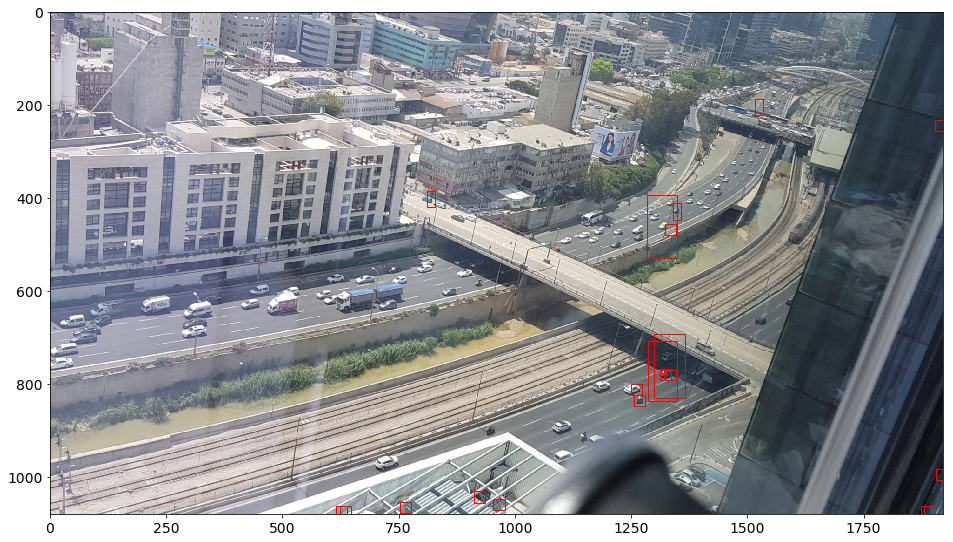

In [22]:
plt.figure(figsize=(16,10))

plt.imshow(image)

ax = plt.gca()
for i in range(len(scores))[:20]:
    ax.add_patch(mpl.patches.Rectangle((roi[i,1],roi[i,0]), (roi[i,3]-roi[i,1]), (roi[i,2]-roi[i,0]),
                                       color='red', fill=False, label='Proposal box' if i==0 else None))
